# Emotion detection in text 

Here we make an attempt to detect emotions present in a given text, using Machine Learning.

## Obtaining the data

In [1]:
import numpy as np
import pandas as pd
data = pd.read_csv("data.csv")
data

,emotion,text
0,joy,"During the period of falling in love, each tim..."
1,fear,When I was involved in a traffic accident.
2,anger,When I was driving home after several days of...
3,sadness,When I lost the person who meant the most to me.
4,disgust,The time I knocked a deer down - the sight of ...
...,...,...
7475,anger,Two years back someone invited me to be the tu...
7476,sadness,I had taken the responsibility to do something...
7477,disgust,I was at home and I heard a loud sound of spit...
7478,shame,I did not do the homework that the teacher had...


In [2]:
texts = data["text"].tolist()
texts[:10]

['During the period of falling in love, each time that we met and especially when we had not met for a long time.',
 'When I was involved in a traffic accident.',
 'When I was driving home after  several days of hard work, there was a motorist ahead of me who was driving at 50 km/hour and refused, despite his low speeed to let me overtake.',
 'When I lost the person who meant the most to me.',
 "The time I knocked a deer down - the sight of the animal's injuries and helplessness.  The realization that the animal was so badly hurt that it had to be put down, and when the animal screamed at the moment of death.",
 'When I did not speak the truth.',
 'When I caused problems for somebody because he could not keep the appointed time and this led to various consequences.',
 'When I got a letter offering me the Summer job that I had applied for.',
 'When I was going home alone one night in Paris and a man came up behind me and asked me if I was not afraid to be out alone so late at night.',
 

In [3]:
emotions = data["emotion"].tolist()
emotions[:10]

['joy',
 'fear',
 'anger',
 'sadness',
 'disgust',
 'shame',
 'guilt',
 'joy',
 'fear',
 'anger']

## Test-train split

In [4]:
from sklearn.model_selection import train_test_split

train_features, test_features, train_labels, test_labels = train_test_split(texts, emotions, test_size = 0.2, random_state = 300)

## Preprocessing the features (i.e. texts)

In [5]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [6]:
maxlen = 100            # We will cut the texts after 100 words
max_vocab_size = 7500  # We will only consider the top 7500 words in the dataset

In [7]:
# Encoding each words in the available texts with numbers
tokenizer = Tokenizer(num_words=max_vocab_size)
tokenizer.fit_on_texts(train_features)
sequences = tokenizer.texts_to_sequences(train_features)

In [8]:
# Let's take a look at some of the texts in their vector form
sequences[:2]

[[35,
  79,
  132,
  3,
  777,
  9,
  85,
  41,
  205,
  12,
  2,
  212,
  9,
  969,
  6,
  71,
  12,
  1522,
  84,
  130,
  138,
  15,
  184,
  19,
  281],
 [1378,
  736,
  50,
  16,
  5,
  113,
  29,
  11,
  46,
  255,
  15,
  171,
  2,
  114,
  1,
  7,
  870,
  6,
  303,
  171,
  3,
  533,
  99,
  1,
  7,
  18,
  104]]

In [9]:
from collections import Counter

def peek_at_the_vocab(vocab, no_of_items):
        print(Counter(vocab).most_common(no_of_items))
     
# Let's take a look at the vocabulary used in the conversion
word_index = tokenizer.word_index
peek_at_the_vocab(word_index, 10)

[('rating', 8150), ('bearing', 8149), ('skiers', 8148), ('austrian', 8147), ('jest', 8146), ('immensely', 8145), ('paddling', 8144), ('relaxing', 8143), ('anticipated', 8142), ('photos', 8141)]


In [10]:
len(word_index)

8150

In [11]:
# Making all texts of equal length 'maxlen=100', by removing off
# rest of the part if it's long and adding 0's if it's short
X_train = pad_sequences(sequences, maxlen=maxlen)
X_train

array([[   0,    0,    0, ...,  184,   19,  281],
       [   0,    0,    0, ...,    7,   18,  104],
       [   0,    0,    0, ...,   18,    5,  151],
       ...,
       [   0,    0,    0, ...,    1,   11,  175],
       [   0,    0,    0, ...,   11,   43, 1851],
       [   0,    0,    0, ...,   41,   66, 1477]], dtype=int32)

## Pre-processing labels (i.e. emotions)

In [12]:
emotion_dict = {
            "joy": 0, 
            'fear': 1, 
            "anger": 2, 
            "sadness": 3, 
            "disgust": 4, 
            "shame": 5, 
            "guilt": 6
}


def convert_label(label):
    return emotion_dict[label]

In [13]:
y_train = np.array(list(map(lambda x: convert_label(x), train_labels)))
y_train

array([3, 3, 4, ..., 6, 2, 6])

# Creating the model

In [14]:
from keras import Sequential
from keras.layers import Embedding, Dense, Conv1D, GlobalMaxPooling1D, MaxPooling1D

batch_size = 64
output_size = len(emotion_dict)
embedding_vector_dims = 64

model = Sequential([
    Embedding(max_vocab_size, embedding_vector_dims, input_length=maxlen), 
    Conv1D(190, 2, activation='relu'),
    MaxPooling1D(3),
    Conv1D(190, 4, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(output_size, activation='softmax') 
])

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 64)           480000    
_________________________________________________________________
conv1d (Conv1D)              (None, 99, 190)           24510     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 33, 190)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 30, 190)           144590    
_________________________________________________________________
global_max_pooling1d (Global (None, 190)               0         
_________________________________________________________________
dense (Dense)                (None, 7)                 1337      
Total params: 650,437
Trainable params: 650,437
Non-trainable params: 0
__________________________________________________

## Training the model

In [16]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=4, validation_split=0.2, batch_size=batch_size)

Epoch 1/4
75/75 [==============================] - 4s 44ms/step - loss: 1.9448 - accuracy: 0.1471 - val_loss: 1.8953 - val_accuracy: 0.2615
Epoch 2/4
75/75 [==============================] - 3s 40ms/step - loss: 1.7465 - accuracy: 0.3562 - val_loss: 1.3601 - val_accuracy: 0.5121
Epoch 3/4
75/75 [==============================] - 3s 39ms/step - loss: 0.9702 - accuracy: 0.6696 - val_loss: 1.2287 - val_accuracy: 0.5848
Epoch 4/4
75/75 [==============================] - 3s 40ms/step - loss: 0.5350 - accuracy: 0.8416 - val_loss: 1.3989 - val_accuracy: 0.5840


## Evaluating the results

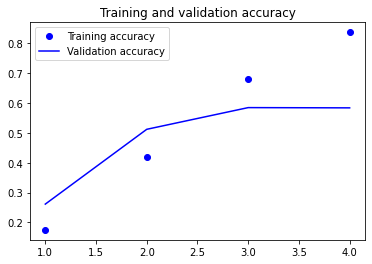

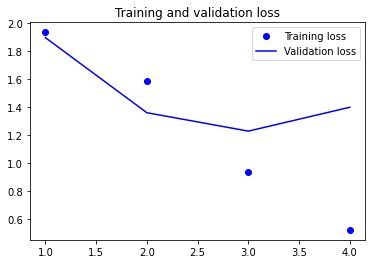

In [17]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [18]:
X_test = pad_sequences(tokenizer.texts_to_sequences(test_features), maxlen=maxlen)
y_test = np.array(list(map(lambda x: convert_label(x), test_labels)))

results = model.evaluate(X_test, y_test)
print(results)

47/47 [==============================] - 0s 6ms/step - loss: 1.3610 - accuracy: 0.5929
[1.3609843254089355, 0.5929144620895386]


## Making predictions

In [19]:
def plot_result(text):
    text_vector = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=maxlen)
    prediction = model.predict(text_vector)

    plt.ylim([0,1])
    plt.xlabel("Emotions")
    plt.ylabel("Probability")
    plt.title("Text: " + text)
    plt.tight_layout()

    plt.bar(range(len(prediction[0])), prediction[0], tick_label=["joy", 'fear', "anger", "sadness", "disgust", "shame", "guilt"])

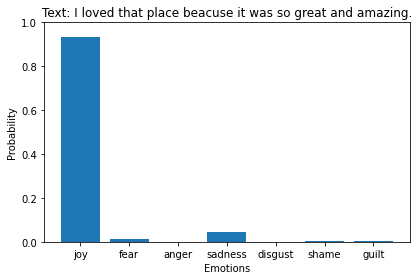

In [20]:
text = "I loved that place beacuse it was so great and amazing."
plot_result(text)

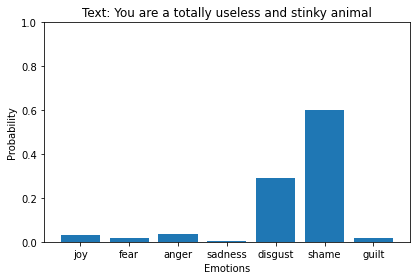

In [25]:
text = "You are a totally useless and stinky animal"
plot_result(text)

## Conclusion

Here we stopped at an accuracy of about 58%, which is very far from being enough, still the results obtained are worth looking at. 

Throughout the different trials and observations, it turned out that two convolutional layers stacked on top of one another can give higher accuracy than other implementations such as using recurrent neural networks to solve this problem. This could be beacuse small portions of the sentence are actually more responsible for determining the emotions present on it rather than the whole sequence.

It should be possible to improve the accuracy of the model through a bigger and better dataset. Also utilising different pre-trained models and word embeddings available on the internet might end up giving us better results. We also need to note that, there will always be a hole in our training data during this kind of analysis, due to the fact that emotions that is being conveyed also depends on the facial expressions and the tone of the speaker's voice, besides the words and their sequences which we're analysing.

## References

1. https://thecleverprogrammer.com/2021/02/19/text-emotions-detection-with-machine-learning/
2. Deep Learning with Python, 1st Edition by François Chollet 